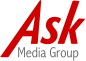
<img src="https://static1.squarespace.com/static/58dc1a1ee4fcb51cbb80a096/t/58ebf4a0f7e0abb89e582c80/1521491055921/?format=1500w">

![No Guns](images/no-guns.png)

<!-- Move the Accel AI logo to the right of the Ask logo, place the no guns image in the middle -->

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

# Taboo Igloo Challenge

> As a website owner, you need to identify user queries about weapons so that you can protect your brand identity.

In today's session we will:

- Add textual features to real queries
- Re-sample data as we have imbalanced classes
- Train classification models
- Compare and contrast model results

**Disclaimer:** We are working with raw user text. We have attempted to remove offensive queries. However, we cannot guarentee that data are free of offensive material.

## Configuration

We will use a several third-party Python in our analysis:

- [**numpy**](https:http://www.numpy.org/): large array
- [**pandas**](https://pandas.pydata.org/): data structures

- [**scikit-learn**](http://scikit-learn.org/stable/index.html): data mining and analysis
- [**imbalanced-learn**](http://contrib.scikit-learn.org/imbalanced-learn/stable/): support for working with imbalanced classes
- [**spaCy**](https://spacy.io/): natural language processing

- [**matplotlib**](https://matplotlib.org/): plotting library

**Note:** We will need to load a word2vec model into spaCy. Since these are large files, spaCy distributes them separately from the core package. We will use the `en_vectors_web_lg` file, which you can install via:

    python -m spacy download en_core_web_lg
    
You should consider running this notebook inside of a Python [virtual environment](https://docs.python.org/3/library/venv.html) if you are not running this notebook on [onepanel.io](https://www.onepanel.io/). Virtual environments mitigate the problems of managing system-wide packages.

In [1]:
import numpy as np
import pandas as pd

import sklearn as sk
from sklearn.decomposition import PCA
import imblearn
import spacy

import matplotlib.pyplot as plt

Let's also get extra space for making inline plots -- this lets us place plots side by side.

In [18]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10,6)

Populating the interactive namespace from numpy and matplotlib


/Users/strykera/Library/Python/3.6/lib/python/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Load

Our data in a [JSON lines](http://jsonlines.org/) format. This format allows us to avoid some of the limitation of  comma separated value (CSV) files.

    [" Patty Hearst photos", false]
    ["AK-47", true]
    
We will use the Pandas [`read_json`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_json.html) method to read the file into a DataFrame. The argument `lines=True` instructs the parser to treat each line as a JSON object.

In [23]:
weapons = pd.read_json("wepons-sample.jsonl", lines=True)\
            .rename(columns={0: "query", 1: "weapon"})
weapons.head(20)

,query,weapon
0,Hallmark number 7606,False
1,Airsoft paintball guns,True
2,бетсити обувь,False
3,Who sings sometimes I give myself the creeps,False
4,geauga county Court Dockets,False
5,County Office of Education's 18th Annual Count...,False
6,osha scaffold tie-off for scaffold erectors,False
7,pandora radgmailio,False
8,findanoffenderga,False
9,eagles live centre,False


Let's see how many observations we have in each class:

In [3]:
weapons.groupby('weapon').count()

,query
weapon,
False,19914
True,86


This confirms our suspicion that we have an imblanced class problem.

## Transform

We will transform the data in the following ways:

1. Create textual features for each query. We will use a [word2vec](https://en.wikipedia.org/wiki/Word2vec) approach to create a [distributed representation](https://en.wikipedia.org/wiki/Artificial_neural_network#distributed_representation) for the queries. This transformation creates the features that we will use to predict whether a query is about weapons.

2. Re-sample the data to account for having imblanced classes. Classification estimators do not work well when nearly all the data are in one class, as is our situation. This step balances the classes so that we will can estimate models.

3. Split the data into train and test sets so that we can use cross-validation to check our predictions.

### Generate textual features

The idea of [word2vec](https://en.wikipedia.org/wiki/Word2vec) is that we can project words into a vector space. Word vectors with similar context and meaning are in close proximity. This transformation results in a vector for each query. We will use these vectors as the features in our model.

#### Create the pipeline

[Natural-language processing](https://en.wikipedia.org/wiki/Natural-language_processing) packages, such as [spaCy](https://spacy.io), begin with building a pipeline. The pipeline contains the algorithms and data that we will apply to our text. The function `spacy.load()` builds an NLP pipeline from a model file. The [`en_core_web_lg`](https://spacy.io/models/en#en_core_web_lg) model file contains data from a web crawl of news, blogs, and comments.

In [4]:
nlp = spacy.load("en_core_web_lg")

#### Prune the vocabulary

From our point of view, we don't need to distinguish between "cat" and "feline". The [`prune_vectors`](https://spacy.io/api/vocab#prune_vectors) method reduces the vocabularly, and hence the computational effort, without much impact on the model performance.

In [ ]:
removed = nlp.vocab.prune_vectors(500000)

print(f"Removed {len(removed) keys}.")
# let's see what we removed
for key in (k for (i, k) in enumerate(removed.keys()) if i < 5):
    print(f"{key} -> {removed[key]}")

#### Build the feature matrix

The Scikit-learn classifying models takes Numpy arrays as its inputs. Thus, we need an array with one row for each query and one column for each word vector element. We also need to convert the dependent variable in to array. The call to [`nlp.pipe`](https://spacy.io/api/pipe#pipe) allows spaCy to run through all of our queries in paralle.

In [5]:
X = np.zeros((len(weapons), nlp.vocab.vectors_length), dtype=np.float32)
y = np.array(weapons['weapon'])

# parse all the all the queries in parallel
for (i, doc) in enumerate(nlp.pipe((str(x) for x in weapons['query']))):
    # store each word vector as a row
    X[i,] = doc.vector

#### Visualize the results

Let's take a look at this data so that we understand what we have. We will use [Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) to reduce our vector space to two dimensions that we can graph.

In [7]:
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X)

Next, we define a helper function to capture the plotting logic. We will make several variations of the PCA scatter plot.

In [60]:
def splot(ax, X, y, title, labels=['Weapon', 'Clean'], alpha=0.3, samples=None,
          xlim=[-5, 5], ylim=[-5, 5]):
    if samples is not None and samples < len(X):
        indx = np.random.choice(len(X), samples)
        X = X[indx,]
        y = y[indx]
         
    c_weapon = ax.scatter(X[y, 0], X[y, 1], label=labels[0], alpha=alpha)
    c_clean = ax.scatter(X[y==False, 0], X[y==False, 1], label=labels[1], alpha=alpha)
    ax.set_title(title)
    
    # make the plot look pretty
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_autoscaley_on(False)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return (c_weapon, c_clean)

Now, we are ready to plot the results.

(<matplotlib.collections.PathCollection at 0x1ae995668>,
 <matplotlib.collections.PathCollection at 0x1483de748>)

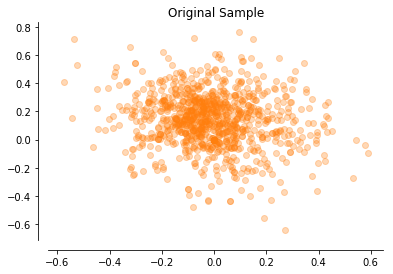

In [9]:
f, ax = plt.subplots(1, 1)
splot(ax, X_vis, y, "Original Sample", samples=1000)

### Cross-validate

The last part of our ET process to group the data into a test and training sets. We split the data evenly since each set is equally import and we have enough observations.

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.5)

We will use the training set for the rest of the model development. We use the testing set once we are ready to validate our results.

### Re-sample



In [10]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y)

Let's visualize the results using PCA technique described above.

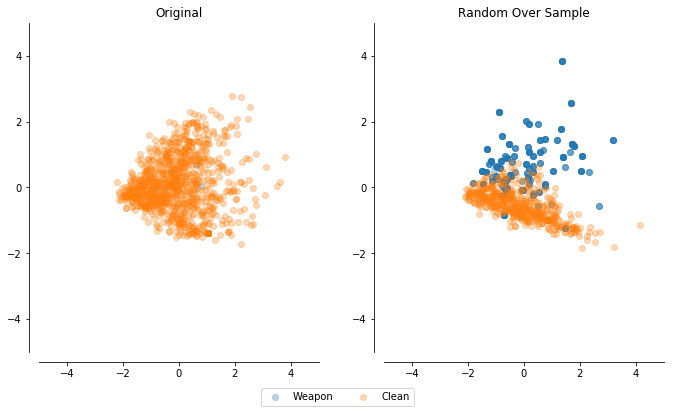

In [61]:
# PCA
X_ros_vis = pca.fit_transform(X_ros)

f, (ax1, ax2) = plt.subplots(1, 2)
cs = splot(ax1, X_vis, y, "Original", samples=1000)
splot(ax2, X_ros_vis, y_ros, "Random Over Sample", samples=1000)

plt.figlegend(cs, ('Weapon', 'Clean'), loc='lower center',
              ncol=2, labelspacing=0.)
plt.tight_layout(pad=3)

Note: we shouldn't expect these to have the same shape as we applied PCA to different matrices

Now your turn. Repeat this example with another re-sampling strategy.

## Train classifiers

Our goal is a classification model that takes a user query and returns the probablity that the query refers to a weapon. We will use a [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) as a benchmark. Logistic models two important properties for our application. Logistic modeles:

- Treat the dependent variable (the query is about weapons) is a linear combination of all the features.
- Require less computation than many other classification algorithms.

These properties make logistic classifiers a suitable as a good benchmark when doing classification modeling. Scikit-learn defines a [`LogisticRegression`](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) for this model.

In [68]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
logit.fit(X_train, y_train)
predicted = logit.predict(X_test)
print(sk.metrics.classification_report(y_test, predicted))

Score for training: 0.990207893943959
Score for testing:  0.9855378125941548
             precision    recall  f1-score   support

      False       0.99      0.98      0.99      9916
       True       0.98      0.99      0.99      9998

avg / total       0.99      0.99      0.99     19914



We 